<a href="https://colab.research.google.com/github/FranciscoHernandez1998/lab5-17004812/blob/master/lab5_17004812.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, GRU

import numpy as np
import matplotlib.pylab as plt
import os, re, json, functools
#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

TensorFlow 2.x selected.


In [3]:
dataset, info = tfds.load('imdb_reviews/bytes', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
info

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/bytes/1.0.0.incomplete2EKUKO/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/bytes/1.0.0.incomplete2EKUKO/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/bytes/1.0.0.incomplete2EKUKO/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/bytes/1.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<ByteTextEncoder vocab_size=257>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, 

In [4]:
encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 257


In [5]:
sample_input = 'Hello, world!'
encoded = encoder.encode(sample_input)
decoded = encoder.decode(encoded)
print(encoded, decoded, "\n")

for index in encoded:
  print('{}\t-> {}'.format(index, encoder.decode([index])))

[73, 102, 109, 109, 112, 45, 33, 120, 112, 115, 109, 101, 34] Hello, world! 

73	-> H
102	-> e
109	-> l
109	-> l
112	-> o
45	-> ,
33	->  
120	-> w
112	-> o
115	-> r
109	-> l
101	-> d
34	-> !


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

In [7]:
train_shape = tuple(map(lambda x:x.shape,train_dataset.element_spec))
test_shape = tuple(map(lambda x:x.shape,test_dataset.element_spec))
train_shape, test_shape

((TensorShape([None]), TensorShape([])),
 (TensorShape([None]), TensorShape([])))

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_shape)
test_dataset = test_dataset.padded_batch(BATCH_SIZE,test_shape)

train_dataset.element_spec

(TensorSpec(shape=(None, None), dtype=tf.int64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [0]:
EPOCHS = 2
STEPS_PER_EPOCH = 4
VALIDATION_STEPS = 2

In [0]:
def train(model, epochs=EPOCHS):
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model.fit(train_dataset, epochs=epochs,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=test_dataset,
                      validation_steps=VALIDATION_STEPS
                      )

In [0]:
def plot_accuracy_and_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(10, 10))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1.0])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Cross Entropy')
  plt.ylim([0.0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [12]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          8224      
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 58,017
Trainable params: 58,017
Non-trainable params: 0
_________________________________________________________________


Train for 4 steps, validate for 2 steps
Epoch 1/2
4/4 [==============================] - 50s 12s/step - loss: 0.6939 - accuracy: 0.4961 - val_loss: 0.6942 - val_accuracy: 0.4375
Epoch 2/2
4/4 [==============================] - 52s 13s/step - loss: 0.6926 - accuracy: 0.5312 - val_loss: 0.6949 - val_accuracy: 0.4531


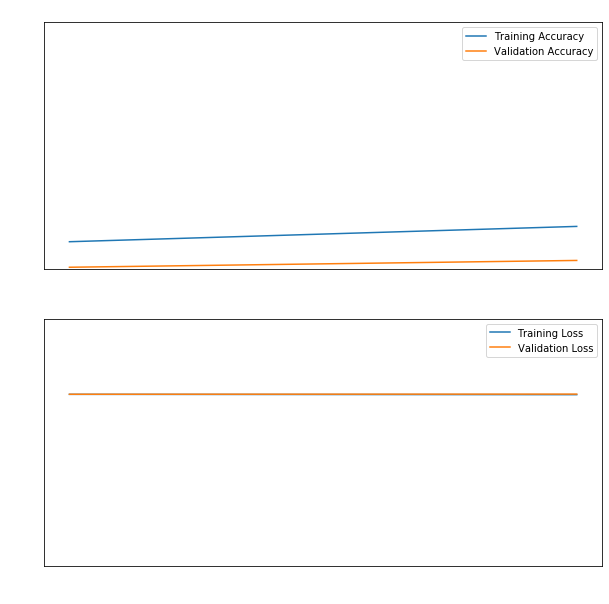

In [13]:
history = train(model)
plot_accuracy_and_loss(history)

In [14]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    Bidirectional(LSTM(64,  return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          8224      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         49664     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 99,169
Trainable params: 99,169
Non-trainable params: 0
_________________________________________________________________


Train for 4 steps, validate for 2 steps
Epoch 1/2
4/4 [==============================] - 110s 27s/step - loss: 0.6935 - accuracy: 0.4961 - val_loss: 0.6940 - val_accuracy: 0.4531
Epoch 2/2
4/4 [==============================] - 96s 24s/step - loss: 0.6926 - accuracy: 0.5234 - val_loss: 0.6968 - val_accuracy: 0.4531


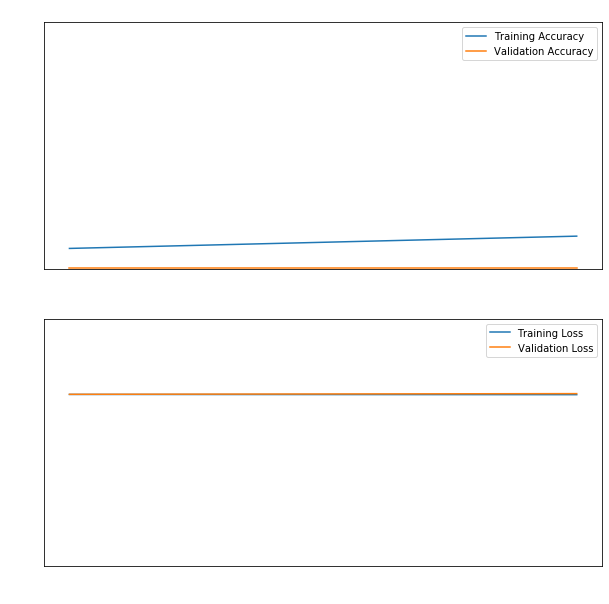

In [15]:
history = train(model)
plot_accuracy_and_loss(history)

In [0]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    Conv1D(32, 3, padding='same', activation = 'relu'),
    MaxPooling1D(2),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          8224      
_________________________________________________________________
gru (GRU)                    (None, 64)                18816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 27,105
Trainable params: 27,105
Non-trainable params: 0
_________________________________________________________________
Train for 4 steps, validate for 2 steps
Epoch 1/2
4/4 [==============================] - 64s 16s/step - loss: 0.6937 - accuracy: 0.4766 - val_loss: 0.6932 - val_accuracy: 0.5391
Epoch 2/2
4/4 [==============================] - 30s 7s/step - loss: 0.6949 - accuracy: 0.4727 - val_loss: 0.6920 - val_accuracy: 0.5469


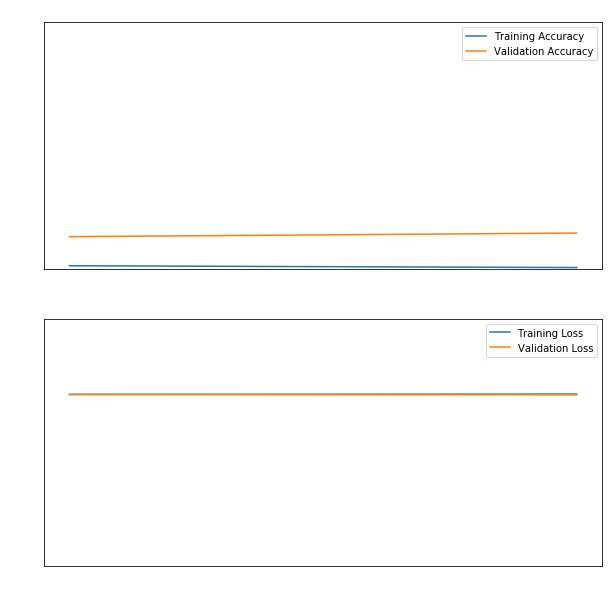

In [17]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    GRU(64),
    Dense(1, activation='sigmoid')
])

model.summary()

history = train(model)
plot_accuracy_and_loss(history)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          8224      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               37632     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 49,089
Trainable params: 49,089
Non-trainable params: 0
_________________________________________________________________
Train for 4 steps, validate for 2 steps
Epoch 1/10
4/4 [==============================] - 23s 6s/step - loss: 0.6940

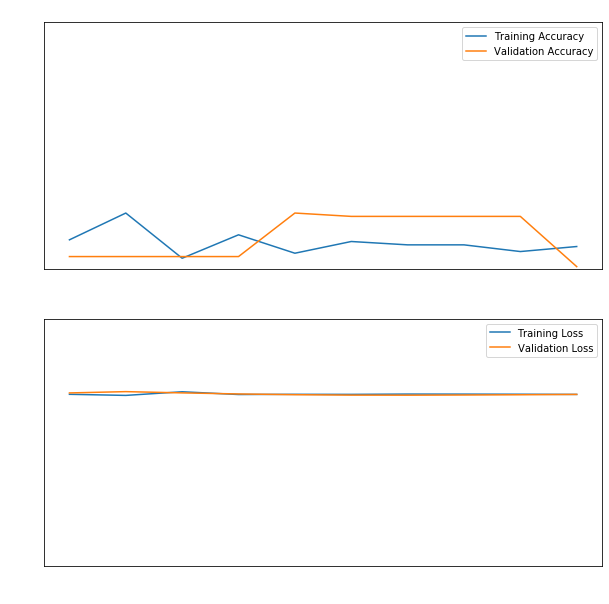

In [18]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    Conv1D(32, 3, padding='same', activation = 'relu'),
    MaxPooling1D(2),
    Bidirectional(GRU(64)),
    Dense(1, activation='sigmoid')
])

model.summary()

history = train(model, epochs=10)
plot_accuracy_and_loss(history)